# Config.

### Import Modules

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# My modules
import sys
sys.path.append('../')
from src import datahandler

### Configure `PATH` for `LOCAL JUPYTER` or `Google Colab`

In [2]:
ENV = 'local'

if ENV =='google':
    # Google Colab Setup
    from os.path import join
    from google.colab import drive
    from google.colab import output

    ROOT = "/content/drive"
    drive.mount(ROOT)

    PATH = "drive/My Drive/data/"

    # Play a sound when training is finished
    def makesound():
        output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/3/34/Sound_Effect_-_Door_Bell.ogg").play()')
    makesound()
elif ENV == 'local':
    # Local Jupyter Setup
    PATH='../'
    
    from src.modeltrainer import *
    
    makesound()

# Load Training Dataset as `raw_data_train`

In [3]:
raw_data_train = pd.read_csv(f'{PATH}INPUT/diamonds_train.csv').drop(columns='Unnamed: 0')
raw_data_train.tail()

,carat,cut,color,clarity,depth,table,x,y,z,price
40340,1.55,Premium,H,VS2,61.3,61.0,7.46,7.39,4.55,11708
40341,0.36,Ideal,D,SI1,60.6,56.0,4.58,4.63,2.79,619
40342,0.57,Very Good,I,VS2,62.2,55.0,5.33,5.34,3.32,1267
40343,1.01,Very Good,F,IF,59.6,62.0,6.47,6.56,3.88,9965
40344,0.54,Ideal,E,SI2,60.4,57.0,5.33,5.27,3.20,1340


## Exploring the features

###### `dtypes`

In [4]:
raw_data_train.dtypes

carat      float64
cut         object
color       object
clarity     object
depth      float64
table      float64
x          float64
y          float64
z          float64
price        int64
dtype: object

### `x`, `y`, `z`
**Watch out** with the `x, y and z` columns which may counfuse our model for having  values == 0 

    LOS DIAMANTES REDONDOS SUELEN TENER UN MEJOR PRECIO QUE LOS DIAMANTES OVALES


In [5]:
(raw_data_train == 0).sum()

carat       0
cut         0
color       0
clarity     0
depth       0
table       0
x           7
y           6
z          17
price       0
dtype: int64

    """
    Although this dataset has no null values, there are dimentional features with values == 0, so we have two options, to take those rows out to train our model, or to eliminate the features completely.
    """

### `depth` 
This ratio is crucial to understand how much light the diamond can refract

In [6]:
raw_data_train.depth.describe()

count    40345.000000
mean        61.750413
std          1.424219
min         43.000000
25%         61.000000
50%         61.800000
75%         62.500000
max         79.000000
Name: depth, dtype: float64

### `cut` 
This is feature is not clearly defined yet. It appears to be subjective.

In [7]:
# Diamond Cut
raw_data_train.cut.value_counts()

Ideal        16090
Premium      10339
Very Good     9036
Good          3694
Fair          1186
Name: cut, dtype: int64

### `color` 
D is the best color, and J is the worst color

In [8]:
# Diamond Color {"DEF" "GHIJ"}
raw_data_train.color.value_counts()

G    8499
E    7351
F    7130
H    6234
D    5074
I    4023
J    2034
Name: color, dtype: int64

### `clarity` 
This follows the [GIA Clarity Scale](https://4cs.gia.edu/en-us/diamond-cut/)

[more info](https://4cs.gia.edu/en-us/diamond-clarity/)

In [9]:
# Diamond Clarity
raw_data_train.clarity.value_counts()

SI1     9751
VS2     9178
SI2     6828
VS1     6101
VVS2    3858
VVS1    2714
IF      1362
I1       553
Name: clarity, dtype: int64

### `carat`
The weight of the diamond. `1 carat == 0.2 grams`

In [10]:
raw_data_train.carat.describe()

count    40345.000000
mean         0.795652
std          0.470806
min          0.200000
25%          0.400000
50%          0.700000
75%          1.040000
max          4.010000
Name: carat, dtype: float64

### `PRICE` == `label` ==  `y`

In [11]:
# LABEL: Diamond Price
raw_data_train.price.value_counts().head()

625    99
789    96
605    95
776    94
596    93
Name: price, dtype: int64

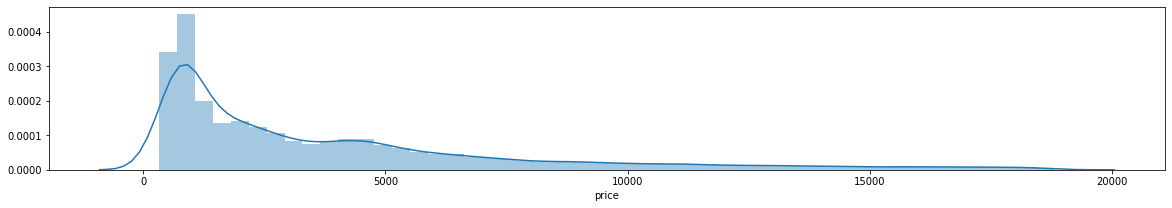

In [12]:
plt.figure(figsize=(20,3))
sns.distplot(raw_data_train.price)

## Notes from a basic investigation:

 - This problem involves the prediction of a price. This implies we are handling a continuous and infinite range of values.

 - The objective is to generate predictions with a low Root Mean Squared Error (RMSE)


"""
- The dataset contains no null values. It is composed of 8 coninuous variables and 3 categorical values.
"""


"""
- After interviewing a Diamond seller, they have reinforced the use of 4 main features `The Four C's`, which are CUT, CARAT, CLARITY, and COLOR, when calculating the price of a diamond... If these features are all "positive", and have "balanced values", (ie: all rounded to a good average), the diamond will sell with a very high price.
"""

"""
 - By looking at the distribution of the `prices`, we can see that the diamonds are more frequently under price of `5000`. Although the maximum price registered is around `20000`, giving this data to our model could actually make it less precise.
"""

"""
 - Existe una publicación periodica que indica los precios de venta de los diamantes, considerando el precio/kilate, dadas ciertas características. Buscar: `diamond rappaport`, para identificar como agrupan los diferentes rangos de kilates.
"""

# Data States

We'll make a dictionary with the different `states` of the data, and we will be updating this dictionary as we create new `data_states`, in order to use them easily with our models. At the end of this notebook, we will be exporting all of out data states to separate csv files

- Proposed Data States:
    - `raw`: The raw data, without any modifications.
    - `max_price`: Raw data, but dropping all rows with a price that goes over a defined `max_price`. It includes categorical and continuous features.
    - `numerical_features`: Turn the categorical (object) dtypes into numerics. (using one-hot encoding or label encoding)
    - `continuous_features`: Discarding all categorical features.
    - `FourCs`: Only include the 4 main features described by the diamond seller.
    

In [13]:
# Create our dictionary
data_input_states = {}

### `data_input_states['raw']`

In [14]:
data_input_states.update({'raw':raw_data_train})
data_input_states['raw'].head(3)

,carat,cut,color,clarity,depth,table,x,y,z,price
0,1.21,Ideal,H,VS2,63.0,57.0,6.73,6.70,4.23,6134
1,0.28,Very Good,D,VVS2,64.0,56.0,4.14,4.17,2.66,532
2,0.42,Premium,F,VS1,61.2,58.0,4.86,4.82,2.96,1103


### `data_input_states['max_price']`

In [15]:
# Define our filter
max_price = 18000

# Making a subset of data with fewer outliers
data = data_input_states['raw'].copy()
data = data[data.price < max_price]
data.price.describe()

data_input_states.update({'max_price':data})
data_input_states['max_price'].head(3)

,carat,cut,color,clarity,depth,table,x,y,z,price
0,1.21,Ideal,H,VS2,63.0,57.0,6.73,6.70,4.23,6134
1,0.28,Very Good,D,VVS2,64.0,56.0,4.14,4.17,2.66,532
2,0.42,Premium,F,VS1,61.2,58.0,4.86,4.82,2.96,1103


### `data_input_states['numerical_features']`


In this case, it would be good to look deeper into how much difference is there between all the GIA `clarity` categories, as they might not follow a linear scale.

In [16]:
data = data_input_states['raw'].copy()
data = datahandler.use_my_numeric_scales(data)
data_input_states.update({'numerical_features':data}) # Add my new data to the data dictionary
data.head(3)

,carat,cut,color,clarity,depth,table,x,y,z,price
0,1.21,0,4,3.6,63.0,57.0,6.73,6.70,4.23,6134
1,0.28,2,0,2.5,64.0,56.0,4.14,4.17,2.66,532
2,0.42,1,2,3.1,61.2,58.0,4.86,4.82,2.96,1103


### `data_input_states['numerical_features_lt10k']`
same as above but with diamonds under 10.000

In [17]:
data = data_input_states['raw'].copy()
data = datahandler.use_my_numeric_scales(data)
data = data[data.price < 10000].copy()
data_input_states.update({'numerical_features_lt10k':data})
data_input_states['numerical_features_lt10k'].head(3)

,carat,cut,color,clarity,depth,table,x,y,z,price
0,1.21,0,4,3.6,63.0,57.0,6.73,6.70,4.23,6134
1,0.28,2,0,2.5,64.0,56.0,4.14,4.17,2.66,532
2,0.42,1,2,3.1,61.2,58.0,4.86,4.82,2.96,1103


### `data_input_states['numfeats_qd']`

We will take or `numerical_features` data_input_state, and enrich it by creating a new column with the depth qualification.

This data state includes all prices, but uses binned depth ratios.

    """
    Posible interpretations of depth to take into account:
    
    Si el depth es mayor al 60% de profundidad, es bueno para el precio

    sin embargo ente 55 y 60% para estar bien proporcionado pero no es el unico factor para evaluar el precio.    
    """

In [18]:
data = data_input_states['numerical_features'].copy()
data['depth_categories'] = data.depth
data['depth_categories'] = data.depth_categories.apply(datahandler.depth_qualifyer)
data_input_states.update({'numfeats_qd':data})

Text(0.5, 1.0, 'Depth Ratio vs Our defined Depth Categories\n (the lower the category, the lower the error)')

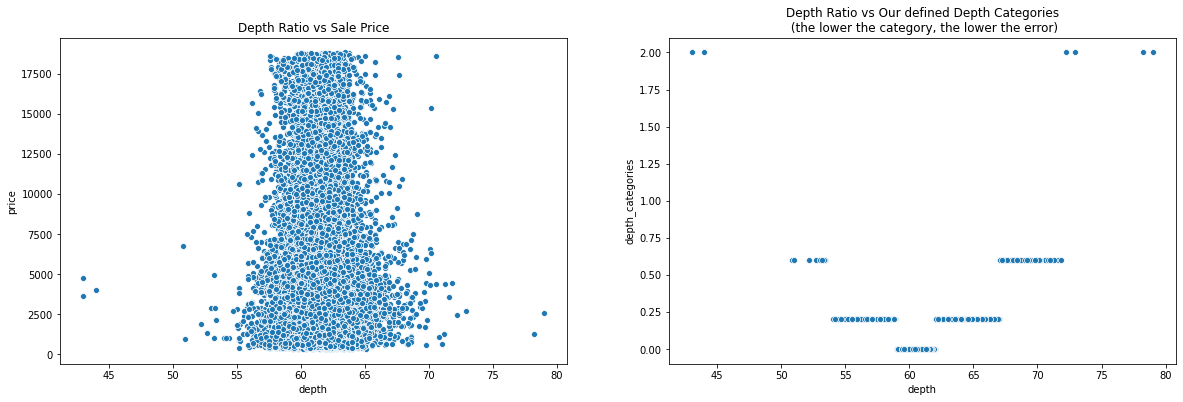

In [19]:
fig,ax=plt.subplots(1,2, figsize=(20,6))
sns.scatterplot(data.depth, data.price, ax=ax[0])
sns.scatterplot(data.depth, data.depth_categories, ax=ax[1])
ax[0].set_title('Depth Ratio vs Sale Price')
ax[1].set_title('Depth Ratio vs Our defined Depth Categories\n (the lower the category, the lower the error)')

### `data_input_states['numfeats_qd_noxyz']`

We will take or `numfeats_qd` data_input_state, and remove the `x` `y` and `z` values, as they are hevily correlated to their `carat` feature, and some of these dimensional values are == 0, which doesn't make sense.

In [20]:
data = data_input_states['numfeats_qd'].copy()
data.drop(columns=['x','y','z'], inplace=True)
data_input_states.update({'numfeats_qd_noxyz':data})
data_input_states['numfeats_qd_noxyz'].head()

,carat,cut,color,clarity,depth,table,price,depth_categories
0,1.21,0,4,3.6,63.0,57.0,6134,0.2
1,0.28,2,0,2.5,64.0,56.0,532,0.2
2,0.42,1,2,3.1,61.2,58.0,1103,0.0
3,0.26,0,4,0.0,61.1,57.0,600,0.0
4,1.10,3,3,6.0,63.4,57.0,4997,0.2


### `data_input_states['numfeats_qd_noxyzt']`

We will take or `numfeats_qd_noxyz` data_input_state, and remove the `table` values, as their correlation to price is very weakly correlated to their `price` label.

In [21]:
data = data_input_states['numfeats_qd_noxyz'].copy()
data.drop(columns=['table'], inplace=True)
data_input_states.update({'numfeats_qd_noxyzt':data})
data_input_states['numfeats_qd_noxyzt'].head(3)

,carat,cut,color,clarity,depth,price,depth_categories
0,1.21,0,4,3.6,63.0,6134,0.2
1,0.28,2,0,2.5,64.0,532,0.2
2,0.42,1,2,3.1,61.2,1103,0.0


# Correlation Matrix

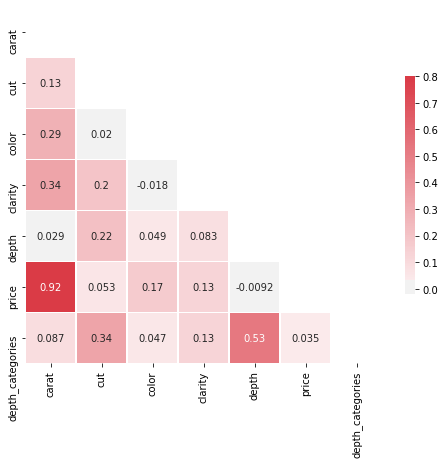

In [22]:
datahandler.corr_matrix(data_input_states['numfeats_qd_noxyzt'])

# Generate Output datasets
From this notebook, we have generated the following list of `data_states` which can be used in the next notebook to train our machine learning model.

In [23]:
data_input_states

{'raw':        carat        cut color clarity  depth  table     x     y     z  price
 0       1.21      Ideal     H     VS2   63.0   57.0  6.73  6.70  4.23   6134
 1       0.28  Very Good     D    VVS2   64.0   56.0  4.14  4.17  2.66    532
 2       0.42    Premium     F     VS1   61.2   58.0  4.86  4.82  2.96   1103
 3       0.26      Ideal     H      IF   61.1   57.0  4.16  4.12  2.53    600
 4       1.10       Good     G     SI1   63.4   57.0  6.52  6.55  4.14   4997
 ...      ...        ...   ...     ...    ...    ...   ...   ...   ...    ...
 40340   1.55    Premium     H     VS2   61.3   61.0  7.46  7.39  4.55  11708
 40341   0.36      Ideal     D     SI1   60.6   56.0  4.58  4.63  2.79    619
 40342   0.57  Very Good     I     VS2   62.2   55.0  5.33  5.34  3.32   1267
 40343   1.01  Very Good     F      IF   59.6   62.0  6.47  6.56  3.88   9965
 40344   0.54      Ideal     E     SI2   60.4   57.0  5.33  5.27  3.20   1340
 
 [40345 rows x 10 columns],
 'max_price':        carat 

In [24]:
for key in data_input_states:
    data_input_states[key].to_csv(f'../OUTPUT/{key}.csv', index=False)

print("done!")

done!
